In [1]:
!pip install -U scikit-learn
import sklearn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#import
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [5]:
#타다 ETA 보정 모델
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/HKT/타다 ETA 보정 모델 dataset.xlsx', sheet_name=1) 
list_date = []

for idx, a in enumerate(tada_eta['created_at_kst']):
  list_str = tada_eta['created_at_kst'][idx].split('T')     #2019-XX-XXT00:00:00 형태를 T로 split
  list_date.append(list_str[0].replace('-',''))             #2019-XX-XX에서 -를 없앰
date = np.asarray(list_date)

tada_eta = tada_eta.drop(['created_at_kst'],1)
tada_eta['date'] = date                                     #20190000 형태로 날짜 입력
tada_eta = tada_eta.astype({'date':str})                    #date칼럼의 데이터타입을 str로
tada_eta.head()

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date
0,10.60,R4L9FL6NVEL4D0,5.65,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,20191201
1,9.20,R3A7JBY7CS6TPD,8.60,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,20191201
2,10.85,R2BIUY1TDK14XE,10.53,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,20191215
3,5.52,R31PU5GNHSGU6C,1.92,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,20190731
4,8.60,R41WR6N1VT42DJ,7.10,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,20190705


In [6]:
# 서울 자치구 생활인구
population = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/HKT/자치구단위_서울생활인구_일별_집계표.csv', encoding='euc-kr') 

idx_pop_rm = []

#열 삭제
population = population.drop(['시군구코드','내국인생활인구수','장기체류외국인인구수',
                              '단기체류외국인인구수','일최대인구수','일최소인구수','일최대이동인구수',
                              '서울외유입인구수','동일자치구행정동간이동인구수','자치구간이동인구수'], axis=1)  

#기준일ID를 통해 2019년 7월이 아니거나 2019년 12월이 아닌 데이터는 삭제
for idx, date in enumerate(population['기준일ID']):
  if date // 100 != 201912 and date // 100 != 201907:
    idx_pop_rm.append(idx)                            #배열에 index 저장

population = population.drop(idx_pop_rm)

population = population.sort_values(by=['기준일ID'])  #기준일ID로 내림차순
population.set_index(np.arange(0,len(population)))    #인덱스를 다시 0부터

,기준일ID,시군구명,총생활인구수,주간인구수(09~18),야간인구수(19~08)
0,20190701,강동구,4.727896e+05,4.432828e+05,4.938659e+05
1,20190701,서울시,1.102817e+07,1.133207e+07,1.081110e+07
2,20190701,종로구,3.351786e+05,4.280593e+05,2.688353e+05
3,20190701,중구,3.749897e+05,5.110968e+05,2.777704e+05
4,20190701,용산구,3.152368e+05,3.437333e+05,2.948822e+05
...,...,...,...,...,...
1607,20191231,강남구,8.824375e+05,1.041885e+06,7.685465e+05
1608,20191231,송파구,8.154661e+05,8.264475e+05,8.076222e+05
1609,20191231,강동구,5.055500e+05,4.775261e+05,5.255670e+05
1610,20191231,서대문구,4.062858e+05,4.187474e+05,3.973846e+05


In [7]:
# 타다 와 자치구 생활인구 join

# tada_eta['pickup_gu'].unique() # 타다 데이터가 1개 작음 -> left join 하기 
# population['시군구명'].unique()

population = population.astype({'기준일ID':str}) # join 하기위해서 형변환
population.rename(columns= {'기준일ID':'date', '시군구명':'pickup_gu'}, inplace=True) # join 하기위해서 칼럼명 변경

In [8]:
population.head()
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 23295 to 18850
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1612 non-null   object 
 1   pickup_gu     1612 non-null   object 
 2   총생활인구수        1612 non-null   float64
 3   주간인구수(09~18)  1612 non-null   float64
 4   야간인구수(19~08)  1612 non-null   float64
dtypes: float64(3), object(2)
memory usage: 75.6+ KB


In [9]:
# 타다 와 자치구 생활인구 left join
tada_eta = pd.merge(left= tada_eta, right= population, how= 'left', on= ['date','pickup_gu'])
tada_eta.drop(['주간인구수(09~18)','야간인구수(19~08)'], axis=1, inplace=True)
tada_eta.head()

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date,총생활인구수
0,10.60,R4L9FL6NVEL4D0,5.65,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,20191201,560967.7469
1,9.20,R3A7JBY7CS6TPD,8.60,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,20191201,329642.2888
2,10.85,R2BIUY1TDK14XE,10.53,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,20191215,225118.1065
3,5.52,R31PU5GNHSGU6C,1.92,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,20190731,400881.2053
4,8.60,R41WR6N1VT42DJ,7.10,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,20190705,377785.3323


In [10]:
# 결측값 확인
tada_eta.isnull().sum()

ATA           0
id            0
api_eta       0
month         0
pickup_lng    0
pickup_lat    0
pickup_gu     0
driver_id     0
driver_lng    0
driver_lat    0
hour          0
date          0
총생활인구수        0
dtype: int64

In [11]:
population[(population['date']=='20191201') & (population['pickup_gu']=='강북구')]

,date,pickup_gu,총생활인구수,주간인구수(09~18),야간인구수(19~08)
19639,20191201,강북구,329642.2888,317415.0326,338376.0432


In [12]:
hour_idx = []

#차량통행속도 데이터
speed_7 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/HKT/차량통행속도_201907.xls')
speed_12 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/HKT/차량통행속도_201912.xls')

len_speed_7 = len(speed_7)
len_speed_12 = len(speed_12)

#7월, 12월 차량통행속도 데이터셋 합치기
speed_12 = speed_12.set_index(np.arange(len_speed_7, len_speed_7+len_speed_12))
speed = pd.concat([speed_7,speed_12])
speed = speed.astype({'일자':str})
speed


for a_idx, a in enumerate(tada_eta['hour']):
  for b_idx, b in enumerate(speed):
    if b != '일자' and b != '날씨' and b != '최고온도(℃)' and b != '최저온도(℃)':
      if int(b[:-1]) == a:
        hour_idx.append(b_idx)
#hour_idx

In [13]:
#날씨, 최고온도, 최저온도 추가
temp_weather = []
temp_max = []
temp_min = []
temp_avg_speed = []

for a_idx, a in enumerate(tada_eta['date']):
  for b_idx, b in enumerate(speed['일자']):
    if a == b:
      temp_weather.append(speed['날씨'][b_idx])
      temp_max.append(speed['최고온도(℃)'][b_idx])
      temp_min.append(speed['최저온도(℃)'][b_idx])
      temp_avg_speed.append(speed[str(hour_idx[a_idx]-1)+'시'][b_idx])
      break

array_weather = np.asarray(temp_weather)
array_max = np.asarray(temp_max) 
array_min = np.asarray(temp_min)
array_avg_speed = np.asarray(temp_avg_speed)

tada_eta['weather'] = array_weather
tada_eta['min_temper'] = array_max
tada_eta['max_temper'] = array_min
tada_eta['avg_speed'] = array_avg_speed



In [14]:
#교통사고건수 데이터

accident_7 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/HKT/교통사고건수_201907.xls')
accident_12 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/HKT/교통사고건수_201912.xls')

#index 25에 있는 NaN값 제거
accident_7 = accident_7.dropna() 
accident_12 = accident_12.dropna() 

len_accident_7 = len(accident_7)
len_accident_12 = len(accident_12)

accident_12 = accident_12.set_index(np.arange(len_accident_7, len_accident_7 + len_accident_12))

accident = pd.concat([accident_7, accident_12])

accident['사고월'] = accident['사고월'].replace('07월','7')
accident['사고월'] = accident['사고월'].replace('12월','12')

for a in accident:
  if accident[a].dtypes == object:
    for idx, b in enumerate(accident[a]):
      if b == '-':                                    #-로 기입되어있는 값을 0으로 바꾸기 위함
        accident.loc[idx, a] = float(0)
        

for idx, a in enumerate(accident):
  if a != '시군구' and a != '사고월':
    accident = accident.astype({a:'float'})
    

In [15]:
####################################################
#어느 구와 어느 월에 사고났는지 index를 저장하는 셀#
####################################################
tmp_idx = []             #tada_eta 데이터에서 각 데이터가 어느 월, 어느 구에서 이뤄졌는지 index를 저장하는 배열
tmp_accident = []
tmp_accident_prob = []

#구별, 일별 사고 데이터 
for a_idx, a in enumerate(tada_eta['pickup_gu']):
  if tada_eta['month'][a_idx] == 7:                                                           #시군구는 월별로 다 있기 때문에 구분해야합니다 (그렇기 때문에 월별 데이터셋의 길이가 같습니다.)
    for b_idx, b in enumerate(accident['시군구'][(len_accident_7 * 0):(len_accident_7*1)]):   #만약 1~12월이었다면 (월-1) * len값으로 해야합니다
      if a == b:
        tmp_idx.append(b_idx)

  if tada_eta['month'][a_idx] == 12:
    for b_idx, b in enumerate(accident['시군구'][(len_accident_7 * 1):(len_accident_7*2)]):
      if a == b:
        tmp_idx.append(b_idx + len_accident_7)

In [16]:
list_accident = []
#####################
#교통사고 수를 쓸 때#
#####################
for a_idx, a in enumerate(tada_eta['date']):
  for b_idx, b in enumerate(accident):
    if b != '시군구' and b != '사고월' and b != '합계':
      if a[-2:] == b[:-1]:
        list_accident.append(accident[b][tmp_idx[a_idx]])
        break

array_accident = np.asarray(list_accident)
tada_eta['accident_count'] = array_accident

In [17]:
list_accident_probablity = []
################################
#교통사고가 발생할 확률을 쓸 때#
################################
for a_idx, a in enumerate(tada_eta['date']):
  for b_idx, b in enumerate(accident):
    if b != '시군구' and b != '사고월' and b != '합계':
      if a[-2:] == b[:-1]:
        temp = accident[b][tmp_idx[a_idx]] / accident['합계'][tmp_idx[a_idx]]
        list_accident_probablity.append(temp)
        break

array_accident = np.asarray(list_accident_probablity)
tada_eta['accident_prob'] = array_accident

In [18]:
tada_eta.head()

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date,총생활인구수,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob
0,10.60,R4L9FL6NVEL4D0,5.65,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,20191201,560967.7469,비,6,2,27.5,3.0,0.022059
1,9.20,R3A7JBY7CS6TPD,8.60,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,20191201,329642.2888,비,6,2,27.5,4.0,0.042105
2,10.85,R2BIUY1TDK14XE,10.53,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,20191215,225118.1065,흐림,11,0,27.9,1.0,0.012987
3,5.52,R31PU5GNHSGU6C,1.92,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,20190731,400881.2053,비,28,24,24.9,5.0,0.046729
4,8.60,R41WR6N1VT42DJ,7.10,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,20190705,377785.3323,흐림,35,20,25.4,1.0,0.009346


In [19]:
import copy
tada_eta_copy = copy.deepcopy(tada_eta) 

In [20]:
#date int형으로 변환, date 기준으로 내림차순 정렬
tada_eta_copy["date"] = pd.to_numeric(tada_eta_copy["date"])
tada_eta_copy.sort_values(by="date", axis=0, ascending=True)

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date,총생활인구수,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob
8372,8.82,R3YL6OPH86DGLX,7.70,7,126.926358,37.525349,영등포구,DPP68606,126.929706,37.547499,16,20190701,512833.5195,흐림,29,21,22.5,6.0,0.028302
12624,11.07,R4NY7S1PNS7EPY,9.67,7,127.025169,37.498675,서초구,DMS36779,127.038005,37.483570,22,20190701,618445.7601,흐림,29,21,26.3,2.0,0.009346
4783,13.37,R42YZYCSXRMMZA,9.87,7,126.892355,37.531214,영등포구,DRD57425,126.918541,37.524993,10,20190701,512833.5195,흐림,29,21,22.7,6.0,0.028302
2221,4.03,R31CPZI4GAEH4N,1.72,7,127.060337,37.498025,강남구,DRD47348,127.061573,37.493629,6,20190701,876118.5460,흐림,29,21,32.2,9.0,0.027607
11703,4.65,R4697DF84DGWBL,2.53,7,126.980626,37.475827,관악구,DTN24993,126.977084,37.476427,21,20190701,493968.0891,흐림,29,21,24.9,4.0,0.030303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7942,6.55,R2ULQJQMON745K,4.47,12,127.064822,37.509165,강남구,DTN80664,127.066044,37.505540,16,20191231,882437.4763,눈,-5,-11,20.4,17.0,0.048571
3084,11.40,R42XRX0U59PCZT,5.77,12,127.050911,37.495095,강남구,DCT91188,127.050007,37.503136,8,20191231,882437.4763,눈,-5,-11,27.5,17.0,0.048571
12633,9.50,R3PN9ZKW3LT7NA,6.10,12,127.013163,37.480396,서초구,DHP67241,127.010333,37.491999,22,20191231,609602.6878,눈,-5,-11,25.0,4.0,0.020725
1265,5.02,R4SRL8MDLURHV6,4.18,12,126.970062,37.531345,용산구,DPJ41222,126.960245,37.519600,1,20191231,332169.6558,눈,-5,-11,25.2,3.0,0.033708


In [21]:
#날씨 ordinal encoding
for i, weather in enumerate(tada_eta_copy["weather"]):
  if weather == "비":
    tada_eta_copy["weather"][i] = 0
  elif weather == "눈":
    tada_eta_copy["weather"][i] = 1
  elif weather == "구름 많음":
    tada_eta_copy["weather"][i] = 2
  elif weather == "구름 조금":
    tada_eta_copy["weather"][i] = 2
  elif weather == "흐림":
    tada_eta_copy["weather"][i] = 2
  else:
    tada_eta_copy["weather"][i] = 3

tada_eta_copy["weather"] = pd.to_numeric(tada_eta_copy["weather"])  # int형으로
tada_eta_copy.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykerne

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date,총생활인구수,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob
0,10.60,R4L9FL6NVEL4D0,5.65,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,20191201,560967.7469,0,6,2,27.5,3.0,0.022059
1,9.20,R3A7JBY7CS6TPD,8.60,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,20191201,329642.2888,0,6,2,27.5,4.0,0.042105
2,10.85,R2BIUY1TDK14XE,10.53,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,20191215,225118.1065,2,11,0,27.9,1.0,0.012987
3,5.52,R31PU5GNHSGU6C,1.92,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,20190731,400881.2053,0,28,24,24.9,5.0,0.046729
4,8.60,R41WR6N1VT42DJ,7.10,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,20190705,377785.3323,2,35,20,25.4,1.0,0.009346


In [22]:
# 평균 속도를 구간으로 바꾸기
tada_eta_copy['avg_speed_band'] = pd.cut(tada_eta_copy['avg_speed'], 5) # 5개의 구간으로 나누기
tada_eta_copy.head()

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date,총생활인구수,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob,avg_speed_band
0,10.60,R4L9FL6NVEL4D0,5.65,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,20191201,560967.7469,0,6,2,27.5,3.0,0.022059,"(25.56, 29.28]"
1,9.20,R3A7JBY7CS6TPD,8.60,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,20191201,329642.2888,0,6,2,27.5,4.0,0.042105,"(25.56, 29.28]"
2,10.85,R2BIUY1TDK14XE,10.53,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,20191215,225118.1065,2,11,0,27.9,1.0,0.012987,"(25.56, 29.28]"
3,5.52,R31PU5GNHSGU6C,1.92,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,20190731,400881.2053,0,28,24,24.9,5.0,0.046729,"(21.84, 25.56]"
4,8.60,R41WR6N1VT42DJ,7.10,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,20190705,377785.3323,2,35,20,25.4,1.0,0.009346,"(21.84, 25.56]"


In [23]:
# avg_speed_band 별로 평균 avg_speed 가 어느 정도인지 보여주는 피벗 테이블 
pd.pivot_table(tada_eta_copy, values='avg_speed', columns='avg_speed_band')

avg_speed_band,"(14.381, 18.12]","(18.12, 21.84]","(21.84, 25.56]","(25.56, 29.28]","(29.28, 33.0]"
avg_speed,17.117836,20.375657,23.708009,26.559983,30.955828


In [24]:
# avg_speed_band 를 범주형으로 변경
from sklearn.preprocessing import LabelEncoder

encoder_speed = LabelEncoder()
encoder_speed.fit(tada_eta_copy['avg_speed_band'])
tada_eta_copy['avg_speed_band'] = encoder_speed.transform(tada_eta_copy['avg_speed_band'])

tada_eta_copy.head()

,ATA,id,api_eta,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,date,총생활인구수,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob,avg_speed_band
0,10.60,R4L9FL6NVEL4D0,5.65,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,20191201,560967.7469,0,6,2,27.5,3.0,0.022059,3
1,9.20,R3A7JBY7CS6TPD,8.60,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,20191201,329642.2888,0,6,2,27.5,4.0,0.042105,3
2,10.85,R2BIUY1TDK14XE,10.53,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,20191215,225118.1065,2,11,0,27.9,1.0,0.012987,3
3,5.52,R31PU5GNHSGU6C,1.92,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,20190731,400881.2053,0,28,24,24.9,5.0,0.046729,2
4,8.60,R41WR6N1VT42DJ,7.10,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,20190705,377785.3323,2,35,20,25.4,1.0,0.009346,2


In [25]:
# 서울시 답변 : 
# 인구수 단위는 명입니다.
# 소수점이 있는 이유는 추정된 인구로, 사사오입을 할 경우 오차가 커지기 때문에 소수점까지 서비스 하고 있습니다.

# 총 생활 인구수에서 소수점 버림
tada_eta_copy['총생활인구수'] = np.trunc(tada_eta_copy['총생활인구수'])

In [26]:
#위도, 경도 이상치 확인
condition1 = (tada_eta_copy['driver_lng'] == 0)
condition2 = (tada_eta_copy['driver_lat'] == 0)
condition3 = (tada_eta_copy['pickup_lng'] == 0)
condition4 = (tada_eta_copy['pickup_lat'] == 0)
tada_eta_copy.loc[condition1 | condition2 | condition3 | condition4 , :]

#위도, 경도 이상치 제거
index1 = tada_eta_copy[tada_eta_copy['driver_lng'] == 0].index
tada_eta_copy = tada_eta_copy.drop(index1)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [28]:
#data 통계 => avg_speed min=14.4라서 교통혼잡이 크게 있는 데이터는 아닌 듯 보임 
tada_eta_copy.describe()

,ATA,api_eta,month,pickup_lng,pickup_lat,driver_lng,driver_lat,hour,date,총생활인구수,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob,avg_speed_band
count,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,1.391100e+04,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000,13911.000000
mean,8.388695,6.173760,10.145712,127.002392,37.527516,127.002584,37.527568,13.279419,2.019103e+07,594895.758249,1.047444,14.362088,6.531306,24.286105,6.539645,0.032883,2.192366
std,4.093091,3.150104,2.415259,0.057432,0.031146,0.058214,0.031596,6.970374,2.416525e+02,220019.110621,1.114208,12.535101,12.798460,3.316250,4.400182,0.015288,0.937486
min,0.430000,0.000000,7.000000,126.798391,37.439779,126.749196,37.445627,0.000000,2.019070e+07,213241.000000,0.000000,-5.000000,-11.000000,14.400000,0.000000,0.000000,0.000000
25%,5.470000,3.810000,7.000000,126.969020,37.503893,126.967732,37.503969,8.000000,2.019072e+07,394735.000000,0.000000,4.000000,-4.000000,22.100000,3.000000,0.022857,2.000000
50%,7.780000,5.950000,12.000000,127.013615,37.523342,127.013484,37.522801,14.000000,2.019121e+07,531399.000000,1.000000,8.000000,0.000000,24.300000,6.000000,0.032000,2.000000
75%,10.520000,8.180000,12.000000,127.040498,37.551463,127.041350,37.551958,19.000000,2.019122e+07,812204.000000,2.000000,28.000000,21.000000,26.000000,9.000000,0.042553,3.000000
max,44.780000,25.280000,12.000000,127.174993,37.686526,127.174070,37.683888,23.000000,2.019123e+07,958954.000000,3.000000,36.000000,26.000000,33.000000,19.000000,0.115702,4.000000


In [29]:
# 필요없는 값 삭제 
tada_eta_copy.drop(['id', 'pickup_gu'], axis=1, inplace=True)

In [30]:
tada_eta_copy.rename(columns= {'총생활인구수':'po_cnt'}, inplace=True) 
tada_eta_copy.head()

,ATA,api_eta,month,pickup_lng,pickup_lat,driver_id,driver_lng,driver_lat,hour,date,po_cnt,weather,min_temper,max_temper,avg_speed,accident_count,accident_prob,avg_speed_band
0,10.60,5.65,12,127.091399,37.624545,DST52944,127.069978,37.616472,0,20191201,560967.0,0,6,2,27.5,3.0,0.022059,3
1,9.20,8.60,12,127.023351,37.625564,DPC72995,127.026479,37.604711,0,20191201,329642.0,0,6,2,27.5,4.0,0.042105,3
2,10.85,10.53,12,126.881154,37.481641,DPP94923,126.906225,37.452167,0,20191215,225118.0,2,11,0,27.9,1.0,0.012987,3
3,5.52,1.92,7,126.988375,37.567897,DCT73585,126.991170,37.566416,0,20190731,400881.0,0,28,24,24.9,5.0,0.046729,2
4,8.60,7.10,7,126.988684,37.566716,DPJ86237,127.006860,37.571164,0,20190705,377785.0,2,35,20,25.4,1.0,0.009346,2


In [31]:
tada_eta_copy.info() # object 형 데이터 있는지 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13911 entries, 0 to 13915
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ATA             13911 non-null  float64
 1   api_eta         13911 non-null  float64
 2   month           13911 non-null  int64  
 3   pickup_lng      13911 non-null  float64
 4   pickup_lat      13911 non-null  float64
 5   driver_id       13911 non-null  object 
 6   driver_lng      13911 non-null  float64
 7   driver_lat      13911 non-null  float64
 8   hour            13911 non-null  int64  
 9   date            13911 non-null  int64  
 10  po_cnt          13911 non-null  float64
 11  weather         13911 non-null  int64  
 12  min_temper      13911 non-null  int64  
 13  max_temper      13911 non-null  int64  
 14  avg_speed       13911 non-null  float64
 15  accident_count  13911 non-null  float64
 16  accident_prob   13911 non-null  float64
 17  avg_speed_band  13911 non-null 

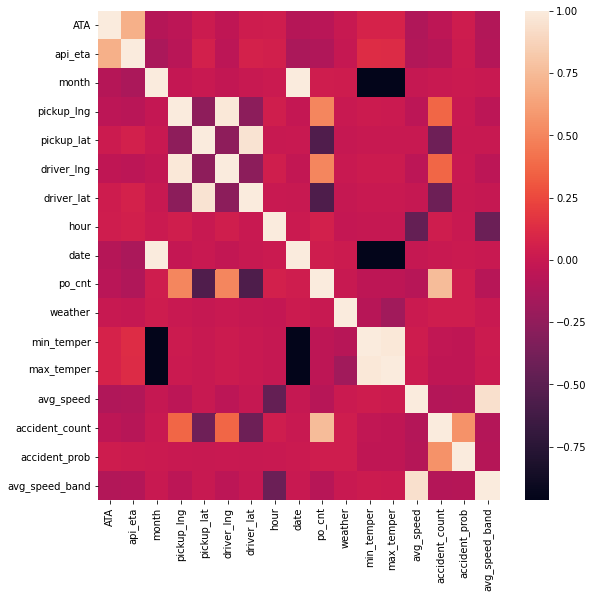

In [32]:
# heatmap 으로 ATA 에 영향이 가장 큰 featrue 찾아보기 -> distance, min temp, max temp 정도

plt.figure(figsize=(9, 9))
corr = tada_eta_copy.corr()
sns.heatmap(corr)
plt.show()

### 평균속도를 구간으로 나누어서 이상치제거가 의미 없는 듯. ###

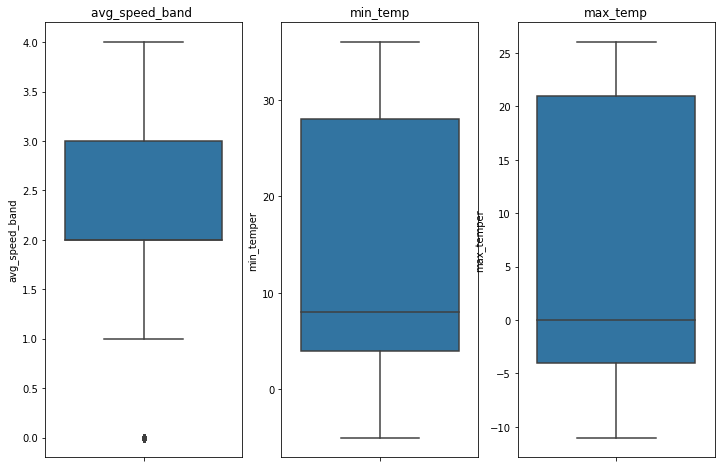

In [33]:
# #box plot 으로 avg_speed_band, min_temper, max_temper 이상치 확인
fig, ax = plt.subplots(1,3, figsize = (12, 8))    

sns.boxplot(y = 'avg_speed_band', data = tada_eta_copy, ax = ax[0])
ax[0].set_title("avg_speed_band ")

sns.boxplot(y = 'min_temper', data = tada_eta_copy, ax = ax[1])
ax[1].set_title("min_temp")

sns.boxplot(y = 'max_temper', data = tada_eta_copy, ax = ax[2])
ax[2].set_title("max_temp")

plt.show()

In [ ]:
# # 이상치 제거
# size_q1 = np.percentile(tada_eta_copy['avg_speed_band'], 25)
# size_q3 = np.percentile(tada_eta_copy['avg_speed_band'], 75)
# Size_iqr = size_q3 - size_q1

# # min_temper, max_temper 는 이상치 없는듯
# size_q1 = np.percentile(tada_eta_copy['min_temper'], 25)
# size_q3 = np.percentile(tada_eta_copy['min_temper'], 75)
# Size_iqr = size_q3 - size_q1

# size_q1 = np.percentile(tada_eta_copy['max_temper'], 25)
# size_q3 = np.percentile(tada_eta_copy['max_temper'], 75)
# Size_iqr = size_q3 - size_q1

# for i, value in enumerate(tada_eta_copy['avg_speed_band']):
#    if value > size_q3 + 1.5 * Size_iqr or value < size_q1 - 1.5 * Size_iqr:
#        tada_eta_copy['avg_speed_band'].iloc[i] = np.nan

# for i, value in enumerate(tada_eta_copy['min_temper']):
#    if value > size_q3 + 1.5 * Size_iqr or value < size_q1 - 1.5 * Size_iqr:
#        tada_eta_copy['min_temper'].iloc[i] = np.nan

# for i, value in enumerate(tada_eta_copy['max_temper']):
#    if value > size_q3 + 1.5 * Size_iqr or value < size_q1 - 1.5 * Size_iqr:
#        tada_eta_copy['max_temper'].iloc[i] = np.nan

In [ ]:
# fig, ax = plt.subplots(1,3, figsize = (12, 8))    # 한 행에 세개의 그래프를 동시에 그리기

# sns.boxplot(y = 'avg_speed_band', data = tada_eta_copy, ax = ax[0])
# ax[0].set_title("avg_speed_band & CI")

# sns.boxplot(y = 'min_temper', data = tada_eta_copy, ax = ax[1])
# ax[1].set_title("min_temp & CI")

# sns.boxplot(y = 'max_temper', data = tada_eta_copy, ax = ax[2])
# ax[2].set_title("max_temp & CI")

# plt.show()

In [34]:
# 교통사고 확률 로 feature
tada_eta_copy2 = copy.deepcopy(tada_eta_copy) 

In [35]:
# 교통사고 수량 으로 feature
X_variables_acc_cnt = tada_eta_copy.drop(['ATA', 'driver_id', 'accident_prob'], axis=1)
Y_class_acc_cnt = tada_eta_copy['ATA']

# 교통사고 확률 로 feature
X_variables_acc_prob = tada_eta_copy2.drop(['ATA', 'driver_id', 'accident_count'], axis=1)
Y_class_acc_acc_prob = tada_eta_copy2['ATA']

In [36]:
X_variables_acc_cnt.head()
#X_variables_acc_prob.head()

,api_eta,month,pickup_lng,pickup_lat,driver_lng,driver_lat,hour,date,po_cnt,weather,min_temper,max_temper,avg_speed,accident_count,avg_speed_band
0,5.65,12,127.091399,37.624545,127.069978,37.616472,0,20191201,560967.0,0,6,2,27.5,3.0,3
1,8.60,12,127.023351,37.625564,127.026479,37.604711,0,20191201,329642.0,0,6,2,27.5,4.0,3
2,10.53,12,126.881154,37.481641,126.906225,37.452167,0,20191215,225118.0,2,11,0,27.9,1.0,3
3,1.92,7,126.988375,37.567897,126.991170,37.566416,0,20190731,400881.0,0,28,24,24.9,5.0,2
4,7.10,7,126.988684,37.566716,127.006860,37.571164,0,20190705,377785.0,2,35,20,25.4,1.0,2


In [37]:
#입력 데이터: 13916개 데이터, 11개 feature, 2차원 행렬(특성 행렬)
print(X_variables_acc_cnt.shape) 
print(X_variables_acc_prob.shape)

(13911, 15)
(13911, 15)


In [38]:
#정답 데이터: 13916개 데이터, 1차원 벡터(타겟 벡터)
print(Y_class_acc_cnt.shape) 
print(Y_class_acc_acc_prob.shape)

(13911,)
(13911,)


In [39]:
# 훈련 데이터와 테스트 데이터 분리 
from sklearn.model_selection import train_test_split

#교통사고 건수
X_train, X_test, Y_train, Y_test = train_test_split(X_variables_acc_cnt, Y_class_acc_cnt, test_size=0.3, random_state=0, shuffle=True)

#교통사고 확률
X_train_prob, X_test_prob, Y_train_prob, Y_test_prob = train_test_split(X_variables_acc_prob, Y_class_acc_acc_prob, test_size=0.3, random_state=0)

ATA 예측을 위한 회귀 분석  
성능지표: mse, rmse  
교통사고 건수 데이터 활용한 RandomForestRegressor 모델  
RandomForestRegressor hyperparameter tuning: GridSearch 통한 hyperparameter  
parameter가 max_depth=6, max_features=13, n_estimators=1000 일 때  
MSE: 8.3938, RMSE: 2.8972로 가장 성능이 좋았다.  

In [39]:
from sklearn.metrics import mean_squared_error

def evaluation(y_test, pred=None): # 평가 함수 
    mse = mean_squared_error(y_test, pred)
    rmse = mse**(1/2.0)

    return mse, rmse

In [40]:
'''Machine Learning Model 1: RandomForestRegressor Basic model'''
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

base_model = RandomForestRegressor(max_depth=6, max_features=13, n_estimators=1000) #기본 모델 정의
base_model.fit(X_train, Y_train) #모델 학습
y_pred = base_model.predict(X_test) #예측값

base_mse, base_rmse = evaluation(Y_test, y_pred)
print('MSE: {0:.4f}, RMSE: {1:.4f}'.format(base_mse, base_rmse))

MSE: 8.3938, RMSE: 2.8972


In [41]:
'''RandomForest GridSearch를 이용한 Hyperparameter tuning'''
from sklearn.model_selection import GridSearchCV

#parameter 설정
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 6, 7],
    'max_features': [9, 13],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#모델 설정
rf = RandomForestRegressor()

#grid search model 생성
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
#모델 학습
grid_search.fit(X_train, Y_train)
#best parameter 확인
grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

In [44]:
best_grid = grid_search.best_estimator_  # GridSearchCV의 refit을 통해 학습이 된 estimator 반환

y_grid_pred = best_grid.predict(X_test)

grid_mse, grid_rmse =  evaluation(Y_test, y_grid_pred)

print('Accuracy: ')
print('MSE: {0:.4f}, RMSE: {1:.4f}'.format(grid_mse, grid_rmse))

Accuracy: 
MSE: 8.4239, RMSE: 2.9024


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

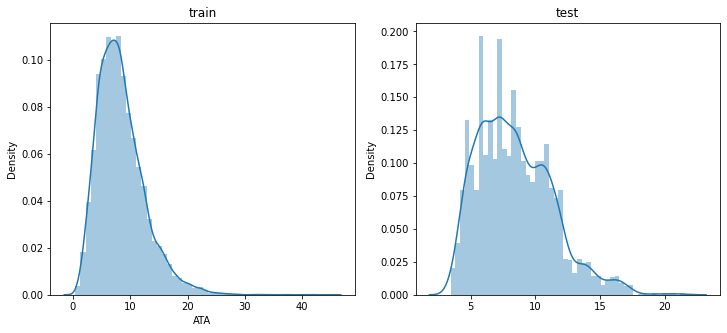

In [45]:
#best model 시각화, hyperparameter tuning 한 것 보다 기본 모델의 성능이 더 좋음 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(Y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(y_pred,ax=ax2,bins=50)
ax2.set(title="test")

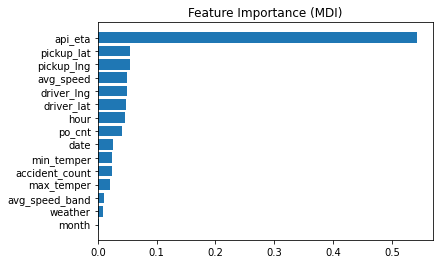

In [46]:
#교통사고 건수 feature importance 시각화, api_eta 중요도 가장 높음 
rf = RandomForestRegressor(bootstrap=True,
                            max_depth=110,
                            max_features=3,
                            min_samples_leaf=3,
                            min_samples_split=8,
                            n_estimators=1000)

rf.fit(X_train, Y_train)

feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .11
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_variables_acc_cnt.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

교통사고 확률 데이터 활용한 RandomForestRegressor 모델  
RandomForestRegressor hyperparameter tuning: GridSearch 통한 hyperparameter  
기본 모델이 hyperparameter 한 모델 보다 성능이 더 좋았다.    
MSE: 8.3981, RMSE: 2.8980  


In [47]:
'''Machine Learning Model 1: RandomForestRegressor Basic model -교통사고 확률 반영한 모델-'''
from sklearn.ensemble import RandomForestRegressor

prob_base_model = RandomForestRegressor() #모델 정의
prob_base_model.fit(X_train_prob, Y_train_prob) #모젤 학습
y_pred_prob = base_model.predict(X_test_prob) #예측 값 

base_mse, base_rmse = evaluation(Y_test_prob, y_pred_prob)
print('MSE: {0:.4f}, RMSE: {1:.4f}'.format(base_mse, base_rmse))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- accident_prob
Feature names seen at fit time, yet now missing:
- accident_count

  warnings.warn(message, FutureWarning)


MSE: 8.3981, RMSE: 2.8980


In [48]:
'''RandomForest GridSearch를 이용한 Hyperparameter tuning'''
from sklearn.model_selection import GridSearchCV

#parameter 설정
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 9, 10, 11],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#기본 모델 설정
rf = RandomForestRegressor()

#grid search model 생성
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
#모델 학습
grid_search.fit(X_train_prob, Y_train_prob)
#best parameter 확인
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 11,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

In [49]:
best_grid = grid_search.best_estimator_ # GridSearchCV의 refit을 통해 학습이 된 estimator 반환

y_grid_pred_prob = best_grid.predict(X_test_prob)

prob_grid_mse, prob_grid_rmse = evaluation(Y_test_prob, y_grid_pred_prob)

print('Accuracy: ')
print('MSE: {0:.4f}, RMSE: {1:.4f}'.format(prob_grid_mse, prob_grid_rmse))

Accuracy: 
MSE: 8.6796, RMSE: 2.9461


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

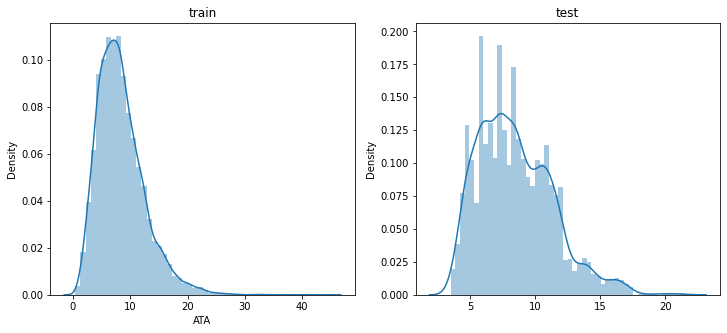

In [50]:
#교통사고 확률 best model 시각화
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(Y_train_prob,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(y_pred_prob,ax=ax2,bins=50)
ax2.set(title="test")

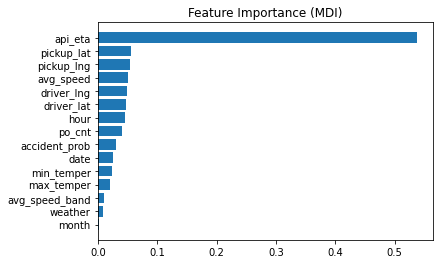

In [51]:
#교통사고 확률 feature importance 시각화 
reg = RandomForestRegressor(bootstrap=True,
                            max_depth=110,
                            max_features=3,
                            min_samples_leaf=3,
                            min_samples_split=8,
                            n_estimators=1000)

reg.fit(X_train_prob, Y_train_prob)

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .11
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_variables_acc_prob.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

결론  
교통사고 건수와 교통사고 확률 데이터를 RandomForestRegressor에 학습 시켰을 때 성능면에서는 큰 차이가 없었다.  
feature importance를 보면 두 데이터 모두 api_eta의 중요도가 가장 높았고  
그 다음으로 pickup 위치의 위도, 경도와 driver 위치의 위도, 경도 순이었다.  


DNN regressor model 이용한 ATA예측  
머신러닝의 결과를 봤을 때 교통사고 건수와 교통사고 확률 데이터의 모델 간 성능 차이가 거의 없었기 때문에 교통사고 건수 데이터를 기반으로 딥러닝 모델을 생성  
tensorflow와 keras 활용=>이건 제 개인적으로 tensorflow와 keras가 pytorch 보다 쉽고 편해서 활용했습니다.  
모델1. linear model로 3 layers 있음 activation function은 relu,
 optimizer는 RMSprop, batch 하나당 10개 샘플 사용, 총 epoch 수 1000개, 성능평가로 mse와 mae 선택  
결과: 테스트 셋 성능 mae: 2.1333 - mse: 9.1143  
train data의 경우 mse 값 줄더드는 반면에 validation data의 경우 오히려 증가하는 추세를 보여 좋은 모델은 아니라고 판단됨.  


In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.7.0


In [41]:
tada_eta_copy3 = copy.deepcopy(tada_eta_copy) 
tada_eta_copy3 = tada_eta_copy3.drop(['driver_id', 'accident_prob', 'avg_speed_band'], axis=1) #필요없는 컬럼 제거
tada_eta_copy3.head()

,ATA,api_eta,month,pickup_lng,pickup_lat,driver_lng,driver_lat,hour,date,po_cnt,weather,min_temper,max_temper,avg_speed,accident_count
0,10.60,5.65,12,127.091399,37.624545,127.069978,37.616472,0,20191201,560967.0,0,6,2,27.5,3.0
1,9.20,8.60,12,127.023351,37.625564,127.026479,37.604711,0,20191201,329642.0,0,6,2,27.5,4.0
2,10.85,10.53,12,126.881154,37.481641,126.906225,37.452167,0,20191215,225118.0,2,11,0,27.9,1.0
3,5.52,1.92,7,126.988375,37.567897,126.991170,37.566416,0,20190731,400881.0,0,28,24,24.9,5.0
4,8.60,7.10,7,126.988684,37.566716,127.006860,37.571164,0,20190705,377785.0,2,35,20,25.4,1.0


In [42]:
train_dataset = tada_eta_copy3.sample(frac=0.8, random_state=0) #train data
test_dataset = tada_eta_copy3.drop(train_dataset.index) #test data

In [43]:
train_stats = train_dataset.describe() #train data 통계값
train_stats = train_stats.transpose() #행, 열 바꾸기 
train_stats

,count,mean,std,min,25%,50%,75%,max
ATA,11129.0,8.395277e+00,4.096668,5.800000e-01,5.470000e+00,7.780000e+00,1.052000e+01,3.693000e+01
api_eta,11129.0,6.176666e+00,3.162709,0.000000e+00,3.780000e+00,5.930000e+00,8.200000e+00,2.528000e+01
month,11129.0,1.014134e+01,2.416445,7.000000e+00,7.000000e+00,1.200000e+01,1.200000e+01,1.200000e+01
pickup_lng,11129.0,1.270023e+02,0.057352,1.267984e+02,1.269690e+02,1.270137e+02,1.270404e+02,1.271750e+02
pickup_lat,11129.0,3.752758e+01,0.031069,3.743978e+01,3.750420e+01,3.752345e+01,3.755133e+01,3.767649e+01
driver_lng,11129.0,1.270024e+02,0.058109,1.267492e+02,1.269673e+02,1.270135e+02,1.270412e+02,1.271741e+02
driver_lat,11129.0,3.752761e+01,0.031498,3.744563e+01,3.750412e+01,3.752305e+01,3.755181e+01,3.768389e+01
hour,11129.0,1.332240e+01,6.966666,0.000000e+00,8.000000e+00,1.400000e+01,1.900000e+01,2.300000e+01
date,11129.0,2.019103e+07,241.731722,2.019070e+07,2.019072e+07,2.019121e+07,2.019122e+07,2.019123e+07
po_cnt,11129.0,5.949677e+05,220079.002628,2.137070e+05,3.948830e+05,5.312070e+05,8.122040e+05,9.589540e+05


In [44]:
train_labels =  train_dataset.pop('ATA')
test_labels =  test_dataset.pop('ATA')

In [45]:
#정규화
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [46]:
normed_train_data = normed_train_data.drop('ATA', axis=1)
normed_test_data = normed_test_data.drop('ATA', axis=1)

In [47]:
print(normed_train_data.shape)
print(normed_test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(11129, 14)
(2782, 14)
(11129,)
(2782,)


In [48]:
print(train_dataset.keys())

Index(['api_eta', 'month', 'pickup_lng', 'pickup_lat', 'driver_lng',
       'driver_lat', 'hour', 'date', 'po_cnt', 'weather', 'min_temper',
       'max_temper', 'avg_speed', 'accident_count'],
      dtype='object')


In [49]:
#선형 회귀 모델 정의
def linear_regression_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae', 'mse'])
  return model

reg_model = linear_regression_model()

In [50]:
example_batch = normed_train_data[:10] #하나의 배치에 10개 샘플 있음   
example_result = reg_model.predict(example_batch) #모델 예측
example_result

array([[-0.77237165],
       [-0.42147312],
       [-0.24308868],
       [ 0.15509841],
       [-0.26263487],
       [-0.05442023],
       [-0.3500712 ],
       [-0.5307614 ],
       [ 0.06863953],
       [ 0.06787894]], dtype=float32)

In [51]:
# 에포크가 끝날 때마다 '*'을 출력
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('*', end='')

EPOCHS = 1000

history = reg_model.fit( #모델 학습
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
******************************************************************************************

In [52]:
hist = pd.DataFrame(history.history) #hist 객체에 통계치 저장되어 있음
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,4.267997,1.559020,4.267997,12.803968,2.697895,12.803968,995
996,4.272285,1.565536,4.272285,12.381701,2.601836,12.381701,996
997,4.330835,1.573095,4.330835,13.560208,2.690950,13.560208,997
998,4.308934,1.565210,4.308934,12.592584,2.641778,12.592584,998
999,4.267331,1.558823,4.267331,12.518589,2.652714,12.518589,999


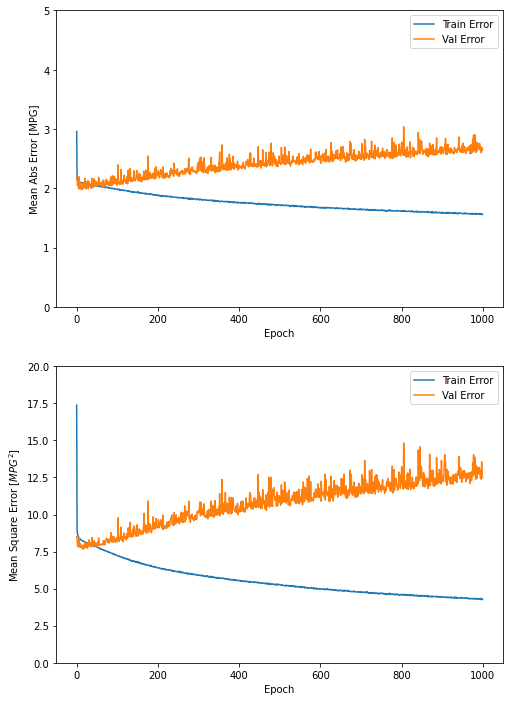

In [53]:
#훈련과정 시각화
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


*****************************************

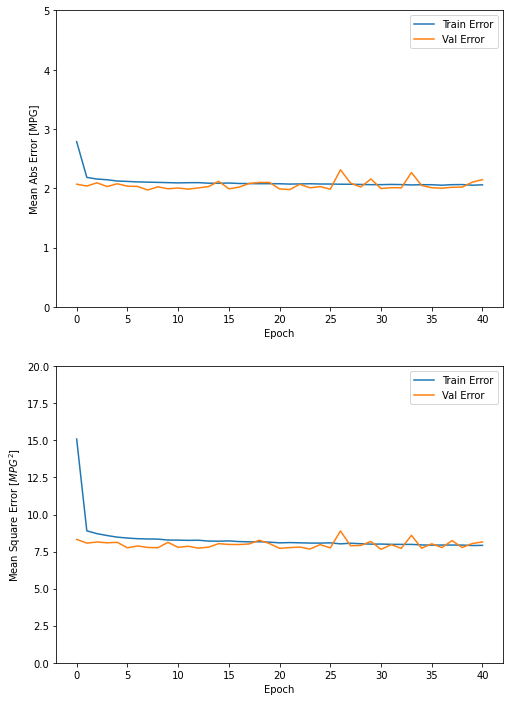

In [55]:
reg_model = linear_regression_model()

# patience = 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = reg_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()]) #earlyStopping 콜백 사용

plot_history(history)

In [56]:
loss, mae, mse = reg_model.evaluate(normed_test_data, test_labels, verbose=2) #test set 성능 평가

print("mae: {:5.2f} MPG".format(mae))

87/87 - 0s - loss: 9.5051 - mae: 2.2527 - mse: 9.5051 - 122ms/epoch - 1ms/step
mae:  2.25 MPG


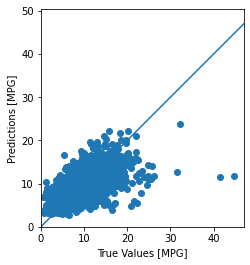

In [57]:
#test set에 있는 sample 사용해 MPG 값 예측
test_predictions = reg_model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

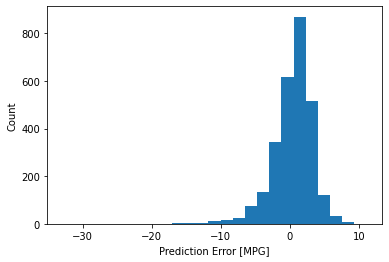

In [58]:
#오차 분포
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

모델2 첫번째 모델과 마찬가지로 교토사고건수 데이터를 사용  
train과 test 8:2로 분리  
dnn regressor model 4 layers, activation function은 relu, input shape은 train 데이터 셋의 column 수 15개, batch size는 32개, epoch 수 200, learning_rate는 0.001 지정, optimizer는 Adam, loss 평가는 mse 선택  
결과: train의 경우 loss가 감소하는 추세인 반면에 validation의 경우 loss가 작게 감소, test set loss: 16.4813


In [86]:
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

x, y = X_variables_acc_cnt, Y_class_acc_cnt
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42) #훈련 데이터 테스트 데이터 분리 

N_BATCH = 32 #batch_size 지정
N_EPOCHS = 200 #epoch수 지정
learning_rate = 0.001 #학습율 지정

In [87]:
#dataset으로 변환
#drop remainder=True 남은 짜투리 버리기
#repeat epoch 반복되도 데이터 계속 공급,
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
                               .shuffle(500)\
                               .batch(N_BATCH, drop_remainder=True)\
                               .repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(N_BATCH)

In [88]:
#모델 생성 4 layers
def dnn_regression_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=16, activation='relu', input_shape=(15,))) #units 노드 개수, input shape는 훈련 데이터  컬럼 개수 15개
    model.add(keras.layers.Dense(units=8, activation='relu'))
    model.add(keras.layers.Dense(units=4, activation='relu'))

    model.add(keras.layers.Dense(units=1))
    return model

In [89]:
#모델 컴파일 설정 
reg_model2 = dnn_regression_model()

#손실함수(loss)=> mse
reg_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [90]:
#한 번에 몇번 업데이트 할지 지정 , drop_reminder=True일 경우 데이터수/배치사이즈 몫만 사용
steps_per_epoch = x_train.shape[0] // N_BATCH


#drop_reminder=False일 경우 데이터수/배치사이즈 나머지 있을 경우 +1 해야함 
validation_steps = int(np.ceil(x_test.shape[0]/N_BATCH))

In [91]:
#학습 
history = reg_model2.fit(train_dataset, #학습 데이터
                    epochs=N_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_dataset, #검증 데이터
                    validation_steps=validation_steps)

Epoch 1/200
347/347 [==============================] - 1s 2ms/step - loss: 104401872.0000 - val_loss: 86.2443
Epoch 2/200
347/347 [==============================] - 1s 2ms/step - loss: 87.0174 - val_loss: 86.2376
Epoch 3/200
347/347 [==============================] - 1s 2ms/step - loss: 86.9786 - val_loss: 86.2281
Epoch 4/200
347/347 [==============================] - 1s 2ms/step - loss: 86.9764 - val_loss: 86.2157
Epoch 5/200
347/347 [==============================] - 1s 2ms/step - loss: 86.8854 - val_loss: 86.2000
Epoch 6/200
347/347 [==============================] - 1s 2ms/step - loss: 86.9807 - val_loss: 86.1807
Epoch 7/200
347/347 [==============================] - 1s 2ms/step - loss: 86.9239 - val_loss: 86.1571
Epoch 8/200
347/347 [==============================] - 1s 2ms/step - loss: 86.8024 - val_loss: 86.1286
Epoch 9/200
347/347 [==============================] - 1s 2ms/step - loss: 86.8422 - val_loss: 86.0942
Epoch 10/200
347/347 [==============================] - 1s 2ms/ste

In [92]:
#test set으로 모델 최종 검증 
print(reg_model2.evaluate(test_dataset)) 

history.history.keys()

87/87 [==============================] - 0s 1ms/step - loss: 16.4813
16.48130226135254


dict_keys(['loss', 'val_loss'])

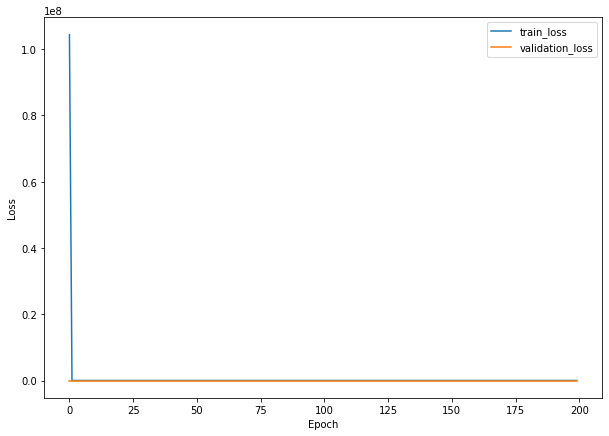

In [93]:
plt.figure(figsize=(10,7))

plt.plot(range(n_epochs), history.history['loss'], label='train_loss')
plt.plot(range(n_epochs), history.history['val_loss'], label='validation_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

k-fold cross validation

In [106]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

교통사고 건수 데이터로 k-fold 진행  
성능 평가 지표 rmse  
사용한 모델: Linear Regression, Decision Tree Regressor, Random Forest Regressor, GradientBoostingRegressor, HistGradientBoostingRegressor  
가장 성능이 좋았던 모델은 GradientBoostingRegressor, rmse 값 0.89

In [107]:
#교통사고 건수 데이터 
X = X_variables_acc_cnt
y = Y_class_acc_cnt
print(X.shape)
print(y.shape)

(13911, 15)
(13911,)


In [108]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 11128, Test set:2783
Fold:2, Train set: 11129, Test set:2782
Fold:3, Train set: 11129, Test set:2782
Fold:4, Train set: 11129, Test set:2782
Fold:5, Train set: 11129, Test set:2782


In [109]:
#rmse 낮을수록 좋음,1 보다 낮은 값 좋음, 0.000001 매우 좋음 
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [110]:
#Linear Regression
score = cross_val_score(linear_model.LinearRegression(), X, y, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-8.35902459 -7.84700384 -8.80154301 -8.88603879 -8.75308801]
rmse= 2.92


In [111]:
#Decision Tree Regressor 
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-15.85896123 -16.92431855 -16.99705374 -19.01105489 -17.79510255]
rmse= 4.16


In [112]:
#Random Forest Regressor 
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

Scores for each fold are: [-8.59344652 -8.36918359 -9.12132844 -9.16482893 -9.0469242 ]
rmse= 2.98


In [113]:
#GradientBoostingRegressor 
score = cross_val_score(ensemble.GradientBoostingRegressor(random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

Scores for each fold are: [-8.10400985 -7.67247831 -8.60321049 -8.6309502  -8.73804992]
rmse= 2.89


In [114]:
#HistGradientBoostingRegressor
score = cross_val_score(ensemble.HistGradientBoostingRegressor(random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

Scores for each fold are: [-8.20243831 -7.80372231 -8.73872712 -8.70518406 -8.68658579]
rmse= 2.90


In [116]:
##GradientBoostingRegressor tuning 
#learning_rate = 0.1
#n_estimators = 100
#subsample = 0.5
#min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#min_weight_fraction_leaf = [0.1, 0.2, 0.3, 0.4, 0.5] 
#max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#min_impurity_decrease
#random_state = [0, 42, 100, 1000]
#max_features = 'auto'
validation_fraction = [0.1, 0.001, 0.0001]

for val in validation_fraction:
    score = cross_val_score(ensemble.GradientBoostingRegressor( loss='squared_error',
                                                                learning_rate=0.1,
                                                                n_estimators=100,
                                                                subsample=0.55,
                                                                random_state=42,
                                                                max_features='auto',
                                                                validation_fraction=val
                                                               ), 
                                                                X, 
                                                                y, 
                                                                cv= kf, 
                                                                scoring="neg_mean_squared_error")
    print(f'Scores for each fold: {score}')
    rmse(score.mean())

Scores for each fold: [-8.16193782 -7.78120222 -8.60718862 -8.6605107  -8.65966013]
rmse= 2.89
Scores for each fold: [-8.16193782 -7.78120222 -8.60718862 -8.6605107  -8.65966013]
rmse= 2.89
Scores for each fold: [-8.16193782 -7.78120222 -8.60718862 -8.6605107  -8.65966013]
rmse= 2.89


교통사고 확률 데이터로 k-fold 진행  
평가지표 rmse  
사용한 모델: Linear Regression, Decision Tree Regressor, Random Forest Regressor, GradientBoostingRegressor, HistGradientBoostingRegressor  
가장 성능이 좋았던 모델은 GradientBoostingRegressor, rmse 값 0.89,  
hyperparameter tuning해도 최저 rmse 값은 0.89 

In [ ]:
#교통사고 확률 데이터 
X_prob = X_variables_acc_prob
Y_prob = Y_class_acc_acc_prob

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X_prob,Y_prob):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

In [ ]:
#Linear Regression
score = cross_val_score(linear_model.LinearRegression(), X_prob, Y_prob, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

In [ ]:
#Decision Tree Regressor 
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X_prob, Y_prob, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

In [ ]:
#Random Forest Regressor 
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X_prob, Y_prob, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

In [ ]:
#GradientBoostingRegressor 
score = cross_val_score(ensemble.GradientBoostingRegressor(random_state= 42), X_prob, Y_prob, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

In [ ]:
#HistGradientBoostingRegressor
score = cross_val_score(ensemble.HistGradientBoostingRegressor(random_state= 42), X_prob, Y_prob, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

In [ ]:
#GradientBoostingRegressor hyperparameter tuning
n_estimators = [40, 50, 60, 70 ]
random_state =[0, 7, 42, 100]
for val in random_state:
    score = cross_val_score(ensemble.GradientBoostingRegressor( learning_rate=0.1,
                                                                n_estimators=40,
                                                                random_state=val
                                                               ), 
                                                                X_prob, 
                                                                Y_prob, 
                                                                cv= kf, 
                                                                scoring="neg_mean_squared_error")
    print(f'Scores for each fold: {score}')
    rmse(score.mean())

**결론:** 교통사고 건수 데이터를 포함한 경우, 최고 성능을 보인 모델은 GradientBoostingRegressor였고 rmse 값 2.89 이었습니다.  
교통사고 확률 데이터를 포함한 경우, 최고 성능을 보인 모델은  
동일하게 GradientBoostingRegressor였고 rmse 값 2.89 이었습니다.  
교통사고 건수 데이터와 교통사고 확률 모두 GradientBoostingRegressor가 rmse 값 2.89로 제일 좋은 성능을 보였습니다.  

In [ ]:
# follium 활용해서 예측한 결과를 지역구로 시각화 할지, 위도경도 활용해서 구간을 시각화 할지 찾아보고 고민해보자.
import folium  # 지도시각화 folium
from folium.plugins import MiniMap

# 지도 생성하기
m = folium.Map(location=[37.5536067,126.9674308],   # 기준좌표: 서울역
               zoom_start=12)

# 미니맵 추가하기
minimap = MiniMap() 
m.add_child(minimap)

# 마커 추가하기
folium.Marker([37.5536067,126.9674308],    # 서울역위치
              tooltip="서울역(마우스올리면보여짐)",
              popup="서울역(클릭하면 보여짐)",
              ).add_to(m)
m